# Instructions
To run the project on Google Colab please add the project folder to your google drive(right click on shared MAIA_AIA -> add to my drive)

In [0]:

#To mount Google drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#Navigate to MAIA-AIA project directory()
%cd "gdrive/My Drive/MAIA_AIA"



/content/gdrive/My Drive/MAIA_AIA


In [0]:
#install libraries
!pip install json_minify
!pip install imutils
!pip install pickle-mixin
!pip install mahotas

  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin
     |████████████████████████████████| 1.5MB 6.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/fb/2a/81/12bc1070527dc81ef856f9d36db9ec0a42e8c14985d005395b
Successfully built mahotas


#Preprocessing - Selective search - Feature extraction(positive images)

Running this section will take around 30 min, however if you want to se the end result(extracted features) keep the **run_positive_ss_from_save =True**

In [0]:
run_positive_ss_from_save = True

In [0]:
import cv2
import random
import progressbar
import h5py
import mahotas
from imutils import paths
import numpy as np
import imutils
from json_minify import json_minify
import json
from imutils.feature import FeatureDetector_create, DescriptorExtractor_create
from pyimagesearch.descriptors import DetectAndDescribe
from pyimagesearch.descriptors import LocalBinaryPatterns
from pyimagesearch.indexer import FeatureIndexer
from _dice import dice
  
if run_positive_ss_from_save:
  bovwFeatures_db = 'output/sumVal_features.hdf5'
  harLBP_db = 'output/sumVal_harLbp_features.hdf5'
  
  bovwFeaturesDB =h5py.File(bovwFeatures_db)
  harLBP_DB =h5py.File(harLBP_db)
    
  bovwFeatures = bovwFeaturesDB["features"]
  haralick = harLBP_DB["haralick_features"]
  lbp = harLBP_DB["lbp_features"]
  
  
  print("BOVW descriptor features (raw features) shape: {}".format(bovwFeatures.shape))
  print("Haralick texture features shape: {}".format(haralick.shape))
  print("LBP features shape: {}".format(lbp.shape))
  
  bovwFeaturesDB.close()
  harLBP_DB.close()
  
else:
  # import the necessary packages
  
  conf = json.loads(json_minify(open('mass.json').read()))
  gtPath = "dataset/groundtruth"
  flagQuality = True

  # initialize the keypoint detector, local invariant descriptor, and the descriptor
  # pipeline
  detector = FeatureDetector_create("GFTT")

  descriptor = DescriptorExtractor_create("ORB")
  #descriptor = DescriptorExtractor_create("RootSIFT")
  dad = DetectAndDescribe(detector, descriptor)

  # initialize the local binary patterns descriptor and initialize the index dictionary
  # where the image filename is the key and the features are the value
  lbp = LocalBinaryPatterns(24, 8)

  # grab the set of ground-truth images and shuffle them
  trnPaths = list(paths.list_images(conf["image_positive"]))
  trnPaths = random.sample(trnPaths, int(len(trnPaths) * 1))
  len(trnPaths)
  # trnPaths = random.sample(trnPaths, int(len(trnPaths)))
  print("[INFO] describing training ROIs...")


  # initialized the # of missed and actual masses
  missed = 0
  actual = 0
  # initialize the number of TPs masses, FPs per image and all FPs
  TPcounter = 0
  num_FP_per_image = []
  num_all_FP = 0
  total_num_rects = 0
  list_num_rects_per_image = []
  accum_num_rects = 0

  # initialize ROIs bb, labels and descriptors
  rectsSS = []
  labels = []
  dataKps = []
  dataDescs = []
  shortlistedRects = []
  num_shortlistedRects = []
  massMatchList = []
  massMatchList_all = []
  gtROIs = []
  images_to_check = []
  counter = 0


  # initializing the lists for each scale to count for patch sum values
  p1 = []
  p2 = []
  p3 = []
  p4 = []

  # initialize sifted features and LBP features
  haralick_features = []
  lbp_featuers = []

  # initialize the numRectsDataset
  numRectsDataset = np.zeros((len(trnPaths), 2), dtype=int)

  # # set up the progress bar
  widgets = ["Reading: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
  pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()

  for (q, imagePath) in enumerate(trnPaths):

      # speed-up using multithreads
      cv2.setUseOptimized(True)
      cv2.setNumThreads(4)

      # initialize lists to keep track or # of masses at each image
      masses_per_Image = []
      rects_per_Image = []

      # extract image ID from path
      imageID = imagePath[imagePath.rfind("/") + 1:-4]

      # read the image
      image_name = conf["image_positive"] + imageID + ".tif"
      image_orig = cv2.imread(image_name)

      # resize the image
      image_orig = imutils.resize(image_orig, height=conf["ImageNewHeight"])

      # CLAHE preprocessing
      image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
      image_orig = clahe.apply(image_orig)

      # load the ground truth file associated with the image and extract the bounding box
      gtpath = "{}/{}".format(gtPath, imageID + ".tif")
      gt = cv2.imread(gtpath)

      # resize ground truth
      gt = imutils.resize(gt, height=conf["ImageNewHeight"])

      # detecting edges in the ground truths
      edged = imutils.auto_canny(gt)

      # join any discontinuity that might happened after detecting edges
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
      closing = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel, iterations=1)

      # find contours in the ground truths
      cnts = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL,
                              cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)

      # clone the original image to show bounding boxes overlaid, and initialize ground
      # truth list of ROIs
      clone = image_orig.copy()
      im_bool = np.zeros((image_orig.shape[0], image_orig.shape[1]), dtype=np.uint8)
      gtROIs = []
      gtArea = []

      # extract the bounding boxes of the ground truth
      for (p, c) in enumerate(cnts):

          # get coordinates
          (x, y, w, h) = cv2.boundingRect(c)

          # crop the region and append it to ground truth ROIs
          roi_bool = im_bool.copy()
          roi_bool[y:y + h, x:x + w] = 255
          gtROIs.append(roi_bool)

      # initialize matching list and mass detected flag
      massMatchList = np.zeros((len(gtROIs), 1), dtype=int)
      num_rects_per_image = 0


      for i in range(1, 5):

          # bb area limiting conditions taking into account each scale
          if i == 1:
              minArea = 50
              maxArea = 500
              minSumVal = 16500
          elif i == 2:
              minArea = 300
              maxArea = 1900
              minSumVal = 24500
          elif i == 3:
              minArea = 700
              maxArea = 2500
              minSumVal = 67500
          else: # i == 4
              minArea = 2300
              maxArea = 15000
              minSumVal = 330000

          # read sifted images
          image_name = conf["sift_pos"] + imageID + "_" + str(i) + ".tif"
          image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)

          # resize image
          image = imutils.resize(image, height=conf["ImageNewHeight"])

          # normalize and covert to uint8
          image = cv2.normalize(image, dst=None, alpha=0, beta=65536, norm_type=cv2.NORM_MINMAX)
          image = (image / 256).astype('uint8')

          # apply CLAHE to sifted images
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
          image = clahe.apply(image)
          image = np.stack((image,) * 3, axis=-1)

          # extract maskID
          maskID = imageID + ".mask.png"

          # load the mask and resize it
          maskpath = "{}/{}".format(conf["masks"], maskID)
          mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)
          mask = imutils.resize(mask, height=conf["ImageNewHeight"])

          # apply mask to the image
          image = cv2.bitwise_and(image, image, mask=mask)

          # create Selective Search Segmentation Object using default parameters
          ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

          # set input image on which we will run segmentation
          ss.setBaseImage(image)

          # Switch to high recall but slow Selective Search method if ssQuality flag is true
          ss.switchToSelectiveSearchQuality() if conf["use_ssQuality"] else ss.switchToSelectiveSearchFast()

          # run selective search segmentation on input image
          rects = ss.process()
          # print('Total Number of initial Proposals: {}'.format(len(rects)))

          # initialize shortlistedRects
          shortlistedRects = []
          numRects = 0
          for rect in rects:

              # calculate area and aspect ratio of the rects
              x, y, w, h = rect
              areaRect = w * h
              aspRatioRect = w / h

              # extrach sifted roi from the sifted image
              sifted_patch = image[y:y + h, x:x + w]

              # calculate the sum of pixels in the ROI
              sumVal = np.sum(sifted_patch)

              # crop the rect binary ROI with in the breast mask and calculate num of zero pixels
              rectRoi = mask[y:y + h, x:x + w]
              numZeros = areaRect - np.count_nonzero(rectRoi, axis=(0, 1))
              zerosRatio = numZeros / areaRect

              # check if rects' areas and aspect ratios within range and add rect to the shortlisted rects
              if areaRect > minArea and areaRect < maxArea:
                  if aspRatioRect > conf["roiMinAspRatio"] and aspRatioRect < conf["roiMaxAspRatio"]:
                      if zerosRatio < conf["zerosRatio"]:
                          if sumVal > minSumVal:
                              if numRects >= 120:
                                  break
                              else:
                                  # append rect to shortlisted rects and extract ROI patch
                                  shortlistedRects.append(rect)
                                  numRects = numRects + 1


          num_shortlistedRects.append(len(shortlistedRects))

          num_rects_per_image += len(shortlistedRects)

          massDetected = False
          for (j, rect) in enumerate(shortlistedRects):
              total_num_rects = total_num_rects + 1
              # clone the image for showing
              clone2 = image_orig.copy()
              clone2 = cv2.cvtColor(clone2, cv2.COLOR_GRAY2BGR)
              # extract bounding box
              x, y, w, h = rect
              roi = image_orig[y:y + h, x:x + w]

              # extract the binary bounding box
              roiSS_bool = im_bool.copy()
              roiSS_bool[y:y + h, x:x + w] = 255
              # print("[INFO] ROI # {}/{}".format(j+1, len(shortlistedRects)))

              # extrach sifted roi from the sifted image
              sifted_patch = image[y:y + h, x:x + w]
              sifted_patch = cv2.cvtColor(sifted_patch, cv2.COLOR_BGR2GRAY)
              patch_value = np.sum(sifted_patch)

              # loop over the ground truth bounding boxes and compute the dice similarity
              for t in np.arange(0, len(gtROIs)):
                  diceCoff = dice(roiSS_bool, gtROIs[t], empty_score=-1)

                  if diceCoff > 0.5:
                      # update matching list, TPs counter and mass detected flag
                      massMatchList[t] = massMatchList[t] + 1
                      TPcounter = TPcounter + 1
                      massDetected = True
                      break

              # check if there was a match for this rect and append the ROI and label
              if massDetected:

                  # extract haralick texture features LBP from sifted images
                  haralick = mahotas.features.haralick(sifted_patch).mean(axis=0)
                  hist = lbp.describe(sifted_patch)
                  haralick_features.append(haralick)
                  lbp_featuers.append(hist)

                  # add coordinates to the list of bounding boxes
                  rectsSS.append(rect)

                  # describe the ROI for bovw
                  (kps, descs) = dad.describe(roi)

                  # skip if no kps detected
                  if kps is None or descs is None:
                      #print("you just lost a mass proposal...")
                      continue
                  dataDescs.append(descs)
                  dataKps.append(kps)
                  l = imageID + "@Mass"
                  labels.append(l)
                  massDetected = False
              else:

                  haralick = mahotas.features.haralick(sifted_patch).mean(axis=0)
                  hist = lbp.describe(sifted_patch)
                  haralick_features.append(haralick)
                  lbp_featuers.append(hist)

                  rectsSS.append(rect)

                  (kps, descs) = dad.describe(roi)

                  if kps is None or descs is None:
                      #print("no worries just lost an FP...")
                      continue

                  dataDescs.append(descs)
                  dataKps.append(kps)
                  l = imageID + "@Not_Mass"
                  labels.append(l)
                  counter += 1

          # add num of detected masses and proposals to the list
          masses_per_Image.append(sum(massMatchList))
          rects_per_Image.append(len(shortlistedRects))

      # add to the accumulator of proposals and index the beginning and ending for
      # each image (# of proposals)
      accum_num_rects += sum(rects_per_Image)

      if q == 0:
          numRectsDataset[q, 0] = 0
          numRectsDataset[q, 1] = accum_num_rects
      else:
          numRectsDataset[q, 0] = numRectsDataset[q-1, 1]
          numRectsDataset[q, 1] = accum_num_rects

      list_num_rects_per_image.append(accum_num_rects)

      # update the # of FPs per image and total FPs
      FPs = sum(rects_per_Image) - sum(massMatchList)
      num_FP_per_image.append(FPs[0])
      num_all_FP = num_all_FP + FPs[0]

      # update the # of actual and missed masses
      actual = actual + len(gtROIs)
      massMatchList_all.append(massMatchList)
      for i in np.arange(0, len(massMatchList)):
          if massMatchList[i] < 10:
              images_to_check.append(imageID)
          if massMatchList[i] < 1:
              missed = missed + 1
              missed_imageID = imageID
              print("missed a mass here: {}".format(missed_imageID))

      pbar.update(q)

  pbar.finish()

  # calculate the average rate of FPs
  avgRects_per_image = np.mean(num_FP_per_image)

  # calculate the average rate of TPs
  m_num = []
  for i in np.arange(0, len(massMatchList_all)):
      m_num.append(min(massMatchList_all[i])[0])

  m_num.sort()
  m_num_avg = np.mean(m_num)

  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
  print("detected {}/{} masses".format(actual-missed, actual))
  print("total num of missed masses = {}".format(missed))
  print("average FP rate = {}".format(avgRects_per_image))
  print("average TP rate = {}".format(m_num_avg))
  print("total num of FPs = {}".format(num_all_FP))
  print("total num of TPs = {}".format(TPcounter))
  print("total num of S.S rects = {}".format(total_num_rects))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
  print("[INFO] storing features to an HDF5 ...")


  # path to the featuers database file
  features_DB = 'output/orb_features.hdf5'

  # initialize the feature indexer, then grab the image paths and randomly shuffle
  # them
  fi = FeatureIndexer(features_DB, estNumImages=35000,
                      maxBufferSize=5000, verbose=True)

  # to loop through each entry in the lists and save them to dataset
  idxs = np.arange(0, len(labels))

  for idx in idxs:
      label = labels[idx]
      kps = dataKps[idx]
      proposals = rectsSS[idx]
      descs = dataDescs[idx]

      # index the features
      fi.add(label, kps, descs)

  # finish the indexing process
  fi.finish()

  #  store proposals indexes and coordinates for each image
  print("[INFO] storing image IDs and patches coordinates...")
  db = h5py.File("output/orb_imageIdxs_rois.hdf5", mode="w")
  db.create_dataset("im_idxs", data=numRectsDataset)
  db.create_dataset("rois", data=rectsSS)
  db.close()
  print("DONE!!!")

  # store haralick and LBP features
  print("[INFO] storing haralick features...")
  db = h5py.File("output/orb_harLbp_features.hdf5", mode="w")
  db.create_dataset("haralick_features", data=haralick_features)
  db.create_dataset("lbp_features", data=lbp_featuers)
  db.close()
  print("DONE!!!")


ModuleNotFoundError: ignored

#Preprocessing - Selective search - Feature extraction(negative images)

Running this section will take around 60 min, however if you want to se the end result(extracted features) keep the **run_negative_ss_from_save = True*

In [0]:
run_negative_ss_from_save = True

In [0]:
# generating region proposals with selective search algorithm
# from preprocessed images and extracting features for
# negative images

# import the necessary packages
import cv2
import random
import progressbar
import h5py
import mahotas
from imutils import paths
import numpy as np
import imutils
from json_minify import json_minify
import json
from imutils.feature import FeatureDetector_create, DescriptorExtractor_create
from pyimagesearch.descriptors import DetectAndDescribe
from pyimagesearch.descriptors import LocalBinaryPatterns
from pyimagesearch.indexer import FeatureIndexer

if run_negative_ss_from_save:
  bovwFeatures_db = 'output/negative_all_features.hdf5'
  harLBP_db = 'output/negative_all_harLbp_features.hdf5'
  
  bovwFeaturesDB =h5py.File(bovwFeatures_db)
  harLBP_DB =h5py.File(harLBP_db)
    
  bovwFeatures = bovwFeaturesDB["features"]
  haralick = harLBP_DB["haralick_features"]
  lbp = harLBP_DB["lbp_features"]
  
  
  print("BOVW descriptor features (raw features) shape: {}".format(bovwFeatures.shape))
  print("Haralick texture features shape: {}".format(haralick.shape))
  print("LBP features shape: {}".format(lbp.shape))
  
  bovwFeaturesDB.close()
  harLBP_DB.close()
  
else:

  conf = json.loads(json_minify(open('mass.json').read()))
  gtPath = conf["image_gt"]

  # initialize the keypoint detector, local invariant descriptor, and the descriptor
  # pipeline
  detector = FeatureDetector_create("GFTT")
  descriptor = DescriptorExtractor_create("ORB")
  dad = DetectAndDescribe(detector, descriptor)

  # initialize the local binary patterns descriptor and initialize the index dictionary
  # where the image filename is the key and the features are the value
  lbp = LocalBinaryPatterns(24, 8)

  # grab the set of background images and shuffle them
  trnPaths = list(paths.list_images(conf["image_negative"]))

  # initializing the number of FPs per image and all FPs
  num_FP_per_image = []
  num_all_FP = 0
  total_num_rects = 0
  list_num_rects_per_image = []
  accum_num_rects = 0

  # initialize ROIs bounding boxes, labels and descriptors
  rectsSS = []
  labels = []
  dataKps = []
  dataDescs = []
  shortlistedRects = []
  num_shortlistedRects = []
  massMatchList = []
  massMatchList_all = []
  gtROIs = []
  images_to_check = []

  # initializing sifted features and LBP features
  haralick_features = []
  lbp_featuers = []

  # initializing the numRectsDataset
  numRectsDataset = np.zeros((len(trnPaths), 2), dtype=int)
  
  print("[INFO] Extractubg ROIs using Selective Search...")

  # set up the progress bar
  widgets = ["Reading: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
  pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()

  # go through all images
  for (q, imagePath) in enumerate(trnPaths):
      
      # speed-up using multithreads
      cv2.setUseOptimized(True)
      cv2.setNumThreads(4)

      # initialize the number of total region proposals and the ones found as masses
      masses_per_Image = []
      rects_per_Image = []

      # extract the image ID
      imageID = imagePath[imagePath.rfind("/") + 1:-4]

      # read the image
      image_name = conf["image_negative"] + imageID + ".tif"
      image_orig = cv2.imread(image_name)

      # resize the image
      image_orig = imutils.resize(image_orig, height=conf["ImageNewHeight"])

      # apply clahe
      image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
      image_orig = clahe.apply(image_orig)

      # initialize matching list and mass detected flag
      massMatchList = np.zeros((len(gtROIs), 1), dtype=int)
      num_rects_per_image = 0
      # initialize counter for unable to describe boxes
      del_rect = 0

      # go through sifted images (4 sifted images per one original image)
      for i in range(1, 5):

          # bb area limiting conditions taking into account each scale
          if i == 1:
              minArea = 50
              maxArea = 500
              minSumVal = 16500
          elif i == 2:
              minArea = 300
              maxArea = 1900
              minSumVal = 24500
          elif i == 3:
              minArea = 700
              maxArea = 2500
              minSumVal = 67500
          else: # i == 4
              minArea = 2300
              maxArea = 15000
              minSumVal = 330000

          # read image
          image_name = conf["sift_neg"] + imageID + "_" + str(i) + ".tif"
          image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)

          # resize image
          image = imutils.resize(image, height=conf["ImageNewHeight"])

          # convert to 8-bit
          image = cv2.normalize(image, dst=None, alpha=0, beta=65536, norm_type=cv2.NORM_MINMAX)
          image = (image / 256).astype('uint8')

          # apply clahe
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
          image = clahe.apply(image)
          image = np.stack((image,) * 3, axis=-1)

          # extract mask ID
          maskID = imageID + ".mask.png"
          maskpath = "{}/{}".format(conf["masks"], maskID)

          # load the mask
          mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)
          mask = imutils.resize(mask, height=conf["ImageNewHeight"])

          # apply mask to the image
          image = cv2.bitwise_and(image, image, mask=mask)

          # create Selective Search Segmentation Object using default parameters
          ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

          # set input image on which we will run segmentation
          ss.setBaseImage(image)

          # Switch to high recall but slow Selective Search method if ssQuality flag is true
          ss.switchToSelectiveSearchQuality() if conf["use_ssQuality"] else ss.switchToSelectiveSearchFast()

          # run selective search segmentation on input image
          rects = ss.process()

          # initialize shortlistedRects
          shortlistedRects = []
          numRects = 0
          for rect in rects:
              # calculate area and aspect ratio of the rects
              x, y, w, h = rect
              areaRect = w * h
              aspRatioRect = w / h

              # extract sifted roi from the sifted image
              sifted_patch = image[y:y + h, x:x + w]
              sumVal = np.sum(sifted_patch)

              # crop the rect binary ROI with in the breast mask and calculate num of zero pixels
              rectRoi = mask[y:y + h, x:x + w]
              numZeros = areaRect - np.count_nonzero(rectRoi, axis=(0, 1))
              zerosRatio = numZeros / areaRect

              # check if rects' areas and aspect ratios within range and add rect to the shortlisted rects
              if areaRect > minArea and areaRect < maxArea:
                  if aspRatioRect > conf["roiMinAspRatio"] and aspRatioRect < conf["roiMaxAspRatio"]:
                      if zerosRatio < conf["zerosRatio"]:
                          if sumVal > minSumVal:
                              if numRects >= 120:
                                  break
                              else:
                                  # append rect to shortlisted rects and extract ROI patch
                                  shortlistedRects.append(rect)
                                  numRects = numRects + 1

          num_shortlistedRects.append(len(shortlistedRects))

          num_rects_per_image += len(shortlistedRects)

          massDetected = False

          for (j, rect) in enumerate(shortlistedRects):
              # add to the counter of total number or boxes
              total_num_rects = total_num_rects + 1
              # extract bounding box from original image
              x, y, w, h = rect
              roi = image_orig[y:y + h, x:x + w]

              # extract sifted roi from the sifted image
              sifted_patch = image[y:y + h, x:x + w]
              sifted_patch = cv2.cvtColor(sifted_patch, cv2.COLOR_BGR2GRAY)

              # describe the ROI
              (kps, descs) = dad.describe(roi)
              # skip if no keypoints detected
              if kps is None or descs is None:
                 # print("no worries just lost an FP...")
                  del_rect += 1
                  continue
              dataDescs.append(descs)
              dataKps.append(kps)
              l = imageID + "@Not_Mass"
              labels.append(l)

              # extract haralick and LBP features from sifted image
              haralick = mahotas.features.haralick(sifted_patch).mean(axis=0)
              hist = lbp.describe(sifted_patch)
              haralick_features.append(haralick)
              lbp_featuers.append(hist)
              rectsSS.append(rect)

          masses_per_Image.append(sum(massMatchList))
          rects_per_Image.append(len(shortlistedRects))

      # add to the accumulator of proposals and index the beginning and ending for each image (# of proposals)
      if del_rect > 0:
          accum_num_rects += (sum(rects_per_Image) - del_rect)
      else:
          accum_num_rects += sum(rects_per_Image)

      if q == 0:
          numRectsDataset[q, 0] = 0
          numRectsDataset[q, 1] = accum_num_rects
      else:
          numRectsDataset[q, 0] = numRectsDataset[q-1, 1]
          numRectsDataset[q, 1] = accum_num_rects

      list_num_rects_per_image.append(accum_num_rects)
      # update the # of FPs per image and total FPs
      FPs = sum(rects_per_Image) - sum(massMatchList)
      num_FP_per_image.append(FPs)
      num_all_FP = num_all_FP + FPs

      pbar.update(q)

  pbar.finish()
  # calculate the average rate of FPs
  avgRects_per_image = np.mean(num_FP_per_image)


  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

  print("average FP rate = {}".format(avgRects_per_image))
  print("total num of FPs = {}".format(num_all_FP))
  print("total num of S.S rects = {}".format(total_num_rects))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
  print("[INFO] storing features to an HDF5 ...")
  
  features_DB = 'output/orb_negative_all_features.hdf5'
  
  # initialize the feature indexer, then grab the image paths and randomly shuffle
  # them
  fi = FeatureIndexer(features_DB, estNumImages=35000,
                      maxBufferSize=5000, verbose=True)
  
  idxs = np.arange(0, len(labels))
  
  for idx in idxs:
      label = labels[idx]
      kps = dataKps[idx]
      proposals = rectsSS[idx]
      descs = dataDescs[idx]
  
      # index the features
      fi.add(label, kps, descs)

  # finish the indexing process
  fi.finish()
  print("[INFO] storing image IDs and patches coordinates...")
  db = h5py.File("output/orb_negative_all_imageIdxs_rois.hdf5", mode="w")
  db.create_dataset("im_idxs", data=numRectsDataset)
  db.create_dataset("rois", data=rectsSS)
  db.close()
  print("DONE!!!")
  
  print("[INFO] storing haralick features...")
  db = h5py.File("output/orb_negative_all_harLbp_features.hdf5", mode="w")
  db.create_dataset("haralick_features", data=haralick_features)
  db.create_dataset("lbp_features", data=lbp_featuers)
  db.close()


BOVW descriptor features (raw features) shape: (7022632, 130)
Haralick texture features shape: (74759, 13)
LBP features shape: (74759, 26)


#Clustering

Running this section will take around 60 mins, however to see the end result of clustering you can keep the **run_clustering_from_save = True**


In [0]:
run_clustering_from_save = True

In [0]:

# import the necessary packages
from __future__ import print_function
from pyimagesearch.ir import Vocabulary
import pickle

if run_clustering_from_save:
  codebook = 'output/equal_vocab_100.cpickle'
  vocab = pickle.loads(open(codebook, "rb").read())
  
  print("BOVW coudebooke clusters(histogram bins) shape: {}".format(vocab.shape))
  
  
  
else:
  # clustering features

  # paths to feature files and defining the number of clusters
  features_db = 'output/sumVal_features.hdf5'
  codebook = 'output/equal_new_vocab_100.cpickle'
  clusters = 100
  percentage = 1.0

  # create the visual words vocabulary
  voc = Vocabulary(features_db)
  vocab = voc.fit(clusters, percentage)

  # dump the clusters to file
  print("[INFO] storing cluster centers...")
  f = open(codebook, "wb")
  f.write(pickle.dumps(vocab))
  f.close()


BOVW coudebooke clusters(histogram bins) shape: (100, 128)


#Extract bag of visual words

For positive images (3 mins - 28,350 patches)

In [0]:
# extract bag of words features

# import the necessary packages
from pyimagesearch.ir import BagOfVisualWords
from pyimagesearch.indexer import BOVWIndexer
import pickle
import h5py

features_db = 'output/sumVal_features.hdf5'
codebook = 'output/equal_vocab_100.cpickle'
bovw_db = 'output/sumVal_all_bovw_100.hdf5'
max_buffer_size = 10000

# load the codebook vocabulary and initialize the bag-of-visual-words transformer
vocab = pickle.loads(open(codebook, "rb").read())
bovw = BagOfVisualWords(vocab)

# open the features database and initialize the bag-of-visual-words indexer
featuresDB = h5py.File(features_db, mode="r")
bi = BOVWIndexer(bovw.codebook.shape[0], bovw_db,
                 estNumImages=featuresDB["image_ids"].shape[0],
                 maxBufferSize=max_buffer_size)

# loop over the image IDs and index
for (i, (imageID, offset)) in enumerate(zip(featuresDB["image_ids"], featuresDB["index"])):
    # check to see if progress should be displayed
    if i > 0 and i % 10 == 0:
        bi._debug("processed {} patches".format(i), msgType="[PROGRESS]")

    # extract the feature vectors for the current image using the starting and
    # ending offsets (while ignoring the keypoints) and then quantize the
    # features to construct the bag-of-visual-words histogram
    features = featuresDB["features"][offset[0]:offset[1]][:, 2:]
    hist = bovw.describe(features)

    # normalize the histogram such that it sums to one then add the
    # bag-of-visual-words to the index
    hist /= hist.sum()
    bi.add(hist)

# close the features database and finish the indexing process
featuresDB.close()
bi.finish()


[PROGRESS] processed 10 patches - 2019-06-21 07:35:59.509433
[PROGRESS] processed 20 patches - 2019-06-21 07:35:59.538196
[PROGRESS] processed 30 patches - 2019-06-21 07:35:59.567600
[PROGRESS] processed 40 patches - 2019-06-21 07:35:59.596228
[PROGRESS] processed 50 patches - 2019-06-21 07:35:59.625939
[PROGRESS] processed 60 patches - 2019-06-21 07:35:59.654450
[PROGRESS] processed 70 patches - 2019-06-21 07:35:59.682936
[PROGRESS] processed 80 patches - 2019-06-21 07:35:59.712219
[PROGRESS] processed 90 patches - 2019-06-21 07:35:59.746840
[PROGRESS] processed 100 patches - 2019-06-21 07:35:59.777536
[PROGRESS] processed 110 patches - 2019-06-21 07:35:59.806296
[PROGRESS] processed 120 patches - 2019-06-21 07:35:59.837769
[PROGRESS] processed 130 patches - 2019-06-21 07:35:59.878418
[PROGRESS] processed 140 patches - 2019-06-21 07:35:59.910561
[PROGRESS] processed 150 patches - 2019-06-21 07:35:59.945082
[PROGRESS] processed 160 patches - 2019-06-21 07:35:59.975447
[PROGRESS] proces

For negative images (8 mins - 74,759 patches)

In [0]:
# extract bag of words features

# import the necessary packages
from pyimagesearch.ir import BagOfVisualWords
from pyimagesearch.indexer import BOVWIndexer
import pickle
import h5py

features_db = 'output/negative_all_features.hdf5'
codebook = 'output/equal_vocab_100.cpickle'
bovw_db = 'output/negative_all_bovw_100.hdf5'
max_buffer_size = 10000

# load the codebook vocabulary and initialize the bag-of-visual-words transformer
vocab = pickle.loads(open(codebook, "rb").read())
bovw = BagOfVisualWords(vocab)

# open the features database and initialize the bag-of-visual-words indexer
featuresDB = h5py.File(features_db, mode="r")
bi = BOVWIndexer(bovw.codebook.shape[0], bovw_db,
                 estNumImages=featuresDB["image_ids"].shape[0],
                 maxBufferSize=max_buffer_size)

# loop over the image IDs and index
for (i, (imageID, offset)) in enumerate(zip(featuresDB["image_ids"], featuresDB["index"])):
    # check to see if progress should be displayed
    if i > 0 and i % 10 == 0:
        bi._debug("processed {} patches".format(i), msgType="[PROGRESS]")

    # extract the feature vectors for the current image using the starting and
    # ending offsets (while ignoring the keypoints) and then quantize the
    # features to construct the bag-of-visual-words histogram
    features = featuresDB["features"][offset[0]:offset[1]][:, 2:]
    hist = bovw.describe(features)

    # normalize the histogram such that it sums to one then add the
    # bag-of-visual-words to the index
    hist /= hist.sum()
    bi.add(hist)

# close the features database and finish the indexing process
featuresDB.close()
bi.finish()


[PROGRESS] processed 10 patches - 2019-06-21 07:39:21.024886
[PROGRESS] processed 20 patches - 2019-06-21 07:39:21.062406
[PROGRESS] processed 30 patches - 2019-06-21 07:39:21.101198
[PROGRESS] processed 40 patches - 2019-06-21 07:39:21.157151
[PROGRESS] processed 50 patches - 2019-06-21 07:39:21.204881
[PROGRESS] processed 60 patches - 2019-06-21 07:39:21.249998
[PROGRESS] processed 70 patches - 2019-06-21 07:39:21.302575
[PROGRESS] processed 80 patches - 2019-06-21 07:39:21.352235
[PROGRESS] processed 90 patches - 2019-06-21 07:39:21.402239
[PROGRESS] processed 100 patches - 2019-06-21 07:39:21.451317
[PROGRESS] processed 110 patches - 2019-06-21 07:39:21.511090
[PROGRESS] processed 120 patches - 2019-06-21 07:39:21.560313
[PROGRESS] processed 130 patches - 2019-06-21 07:39:21.614293
[PROGRESS] processed 140 patches - 2019-06-21 07:39:21.666439
[PROGRESS] processed 150 patches - 2019-06-21 07:39:21.727757
[PROGRESS] processed 160 patches - 2019-06-21 07:39:21.780052
[PROGRESS] proces


# Train the model


In [0]:
# Specify fold number(between 0 and 9) - 10 Folds
fold_num = 0

In [0]:
# import the necessary packages
from __future__ import print_function
import datetime
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import h5py

from sklearn.model_selection import KFold

# flag to use hard training or not
hard_negative = True

# paths to datasets
features_db = 'output/sumVal_features.hdf5'
bovw_db = 'output/sumVal_all_bovw_100.hdf5'
modelPath = 'output/all_model_k' + str(fold_num) + '.cpickle'
imIdxsPath = 'output/sumVal_imageIdxs_rois.hdf5'
newFPath = 'output/sumVal_harLbp_features.hdf5'

# open the databases
featuresDB = h5py.File(features_db)
bovwDB = h5py.File(bovw_db)
imIdxsDB = h5py.File(imIdxsPath)
newFDB = h5py.File(newFPath)

# get the image indexes and other datasets from files
imIdxs = imIdxsDB['im_idxs']
labels = featuresDB['image_ids']
bovw = bovwDB["bovw"]
haralick = newFDB["haralick_features"]
lbp = newFDB["lbp_features"]

print("[INFO] loading data...")

# concatenate all feature vectors
features = np.concatenate((haralick, lbp, bovw), axis=1)

# get number of positive images
num_images = len(imIdxs)
# get the index of for splitting images
im_index = np.arange(0, num_images)

# create a k fold object of 10 folds
kf = KFold(n_splits=10)

# initialize training and testing indexes
idx_train = None
idx_test = None

# get indexes for training and testing of the specific fold
for i, (train_index, test_index) in enumerate(kf.split(im_index)):
    idx_train, idx_test = im_index[train_index], im_index[test_index]
    if i == fold_num:
        break

# get features and labels based on the training indexes
tr_features = None
tr_labels = None
for idx in idx_train:
    if tr_features is None:
        tr_features = features[imIdxs[idx][0]:imIdxs[idx][1]]
        tr_labels = labels[imIdxs[idx][0]:imIdxs[idx][1]]
    else:
        tr_features = np.concatenate((tr_features, features[imIdxs[idx][0]:imIdxs[idx][1]]), axis=0)
        tr_labels = np.concatenate((tr_labels, labels[imIdxs[idx][0]:imIdxs[idx][1]]), axis=0)

# get features and labels based on the testing indexes
ts_features = None
ts_labels = None
for idx in idx_test:
    if ts_features is None:
        ts_features = features[imIdxs[idx][0]:imIdxs[idx][1]]
        ts_labels = labels[imIdxs[idx][0]:imIdxs[idx][1]]
    else:
        ts_features = np.concatenate((ts_features, features[imIdxs[idx][0]:imIdxs[idx][1]]), axis=0)
        ts_labels = np.concatenate((ts_labels, labels[imIdxs[idx][0]:imIdxs[idx][1]]), axis=0)

# strip labels from imageIDs
trainLabels = [l.split("@")[1] for l in tr_labels]
testLabels = [l.split("@")[1] for l in ts_labels]
trainData = tr_features
testData = ts_features

# for hard training
if hard_negative:
    print("[INFO] apply hard mining...")

    negative_bovw_db = 'output/negative_all_bovw_100.hdf5'
    negative_modelPath = 'output/all_model_k' + str(fold_num) + '.cpickle'
    negative_newFPath = 'output/negative_all_harLbp_features.hdf5'
    negative_features_db = 'output/negative_all_features.hdf5'
    negative_imageIdx_db = "output/negative_all_imageIdxs_rois.hdf5"

    negative_bovwDB = h5py.File(negative_bovw_db)
    negative_newFDB = h5py.File(negative_newFPath)
    negative_featuresDB = h5py.File(negative_features_db)
    negative_imageIdxDB = h5py.File(negative_imageIdx_db)

    # load the classifier
    negative_model = pickle.loads(open(negative_modelPath, "rb").read())

    negative_bovw = negative_bovwDB["bovw"]
    negative_haralick = negative_newFDB["haralick_features"]
    negative_lbp = negative_newFDB["lbp_features"]
    negative_labels = negative_featuresDB['image_ids']
    negative_imIdxs = negative_imageIdxDB['im_idxs']

    # prepare the feature vector
    negative_features = np.concatenate((negative_haralick, negative_lbp, negative_bovw), axis=1)

    negative_num_images = len(negative_imIdxs)
    negative_im_index = np.arange(0, negative_num_images)

    # get indexes for training and testing of the specific fold
    N_idx_train = None
    for i, (N_train_index, N_test_index) in enumerate(kf.split(negative_im_index)):
        N_idx_train, N_idx_test = N_train_index, N_test_index
        if i == fold_num:
            break

    N_tr_features = None
    for idx in N_idx_train:
        if N_tr_features is None:
            N_tr_features = negative_features[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]
        else:
            N_tr_features = np.concatenate((N_tr_features, negative_features[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]), axis=0)

    # predict proposals of the negative images and get their probabilities of being a mass
    probs = negative_model.predict_proba(N_tr_features)[0:, 0]
    probs = np.expand_dims(probs, axis=1)

    # concatenate each feature vector with its probability
    hard_data = np.hstack([probs, N_tr_features])
    # sort array to keep high probabilities at the top
    hard_data = hard_data[hard_data[:, 0].argsort()[::-1]]

    # strip feature vectors from probabilities and prepare labels
    hard_data = hard_data[:, 1:]
    hard_labels = [l.split("@")[1] for l in negative_labels]

    # take only in account a portion of the hard data to train
    hard_data = hard_data[0:15000, :]
    hard_labels = hard_labels[0:15000]

    # adding the hard data to the training data
    trainData = np.vstack([trainData, hard_data])
    trainLabels.extend(hard_labels)

    # close negative images datasets
    negative_featuresDB.close()
    negative_bovwDB.close()
    negative_newFDB.close()
    negative_imageIdxDB.close()

    # use this path instead to save the model if hard training is on
    hard_modelPath = 'output/hard_model_k' + str(fold_num) + '.cpickle'
    modelPath = hard_modelPath



print("[INFO] training the model...{}".format(datetime.datetime.now()))

# create a Decision tree base classifier
cart = DecisionTreeClassifier(max_depth=3, class_weight="balanced")
# construct the bagging classifier
model = BaggingClassifier(base_estimator=cart, n_estimators=200, max_samples=0.3)

# train the model
model.fit(trainData, trainLabels)

# show a classification report
print("[INFO] evaluating...{}".format(datetime.datetime.now()))
predictions = model.predict(testData)
print("/////////////////////////////////////////////")
print(classification_report(testLabels, predictions))
conf = confusion_matrix(testLabels, predictions, labels=["Mass", "Not_Mass"])
print("/////////////////////////////////////////////")
print("True/Predicted | Mass      Not Mass          Total")
print("")
print("Mass           |  {}          {}             {}".format(conf[0, 0], conf[0, 1], conf[0, 0] + conf[0, 1]))
print("Not Mass       |  {}          {}            {}".format(conf[1, 0], conf[1, 1], conf[1, 0] + conf[1, 1]))
print("")
print("Total          |  {}         {}            {}".format(conf[0, 0] + conf[1, 0], conf[0, 1] + conf[1, 1], sum(sum(conf))))

# close the databases
featuresDB.close()
bovwDB.close()
imIdxsDB.close()
newFDB.close()

# dump the classifier to file
print("[INFO] dumping classifier to file...")
f = open(modelPath, "wb")
f.write(pickle.dumps(model))
f.close()
print("done")


[INFO] loading data...
[INFO] apply hard mining...


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[INFO] training the model...2019-06-21 09:18:22.564606
[INFO] evaluating...2019-06-21 09:19:41.824222
/////////////////////////////////////////////
              precision    recall  f1-score   support

        Mass       0.60      0.68      0.64       318
    Not_Mass       0.96      0.94      0.95      2529

    accuracy                           0.91      2847
   macro avg       0.78      0.81      0.79      2847
weighted avg       0.92      0.91      0.92      2847

/////////////////////////////////////////////
True/Predicted | Mass      Not Mass          Total

Mass           |  216          102             318
Not Mass       |  146          2383            2529

Total          |  362         2485            2847
[INFO] dumping classifier to file...
done


# Test the model

This section is the last one, keep the flag to see our system's FROC without re-running the code (60 mins for only 10 points)

In [0]:
run_test_model_from_save = True

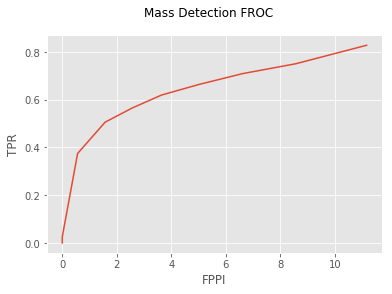

In [0]:
# import necessary packages
from __future__ import print_function
import datetime
import numpy as np
import pickle
import h5py
from sklearn.model_selection import KFold
import cv2
import imutils
from json_minify import json_minify
import json
from sklearn.metrics import confusion_matrix
from _dice import dice
import matplotlib.pyplot as plt


if run_test_model_from_save:
  
  
  frocPath = 'output/froc_points.cpickle'
  froc_points = pickle.loads(open(frocPath, "rb").read())
  
  x = froc_points[:, 2]
  y = froc_points[:, 1]

  # plot the froc curve
  fig = plt.figure()
  plt.style.use("ggplot")
  plt.suptitle('Mass Detection FROC')
  plt.xlabel('FPPI')
  plt.ylabel('TPR')

  plt.plot(x, y)

  
else:
  hard_negative = True

  # initialize froc points array
  froc_points = None

  print("[INFO] Calculating FROC operating points ... {}".format(datetime.datetime.now()))

  for prob_thresh in np.arange(0.5, 1.0, 0.05):       # step = 0.05 ==> 10 points

      overall_TPR = []
      overall_FPPI = []

      for fold_num in np.arange(0, 10):

          # load configuration file and get the path to images
          conf = json.loads(json_minify(open('mass.json').read()))

          # get the file paths
          features_db = 'output/sumVal_features.hdf5'
          bovw_db = 'output/sumVal_all_bovw_100.hdf5'
          modelPath = 'output/all_model_k' + str(fold_num) + '.cpickle'
          imIdxsPath = 'output/sumVal_imageIdxs_rois.hdf5'
          newFPath = 'output/sumVal_harLbp_features.hdf5'

          if hard_negative:
              modelPath = 'output/hard_model_k' + str(fold_num) + '.cpickle'

          # load the classifier
          model = pickle.loads(open(modelPath, "rb").read())

          # open the features and bag-of-visual-words databases
          featuresDB = h5py.File(features_db)
          bovwDB = h5py.File(bovw_db)
          imIdxsDB = h5py.File(imIdxsPath)
          newFDB = h5py.File(newFPath)

          # get the image indexes
          imIdxs = imIdxsDB['im_idxs']
          labels = featuresDB['image_ids']
          bovw = bovwDB["bovw"]
          haralick = newFDB["haralick_features"]
          lbp = newFDB["lbp_features"]

          # features = lbp
          features = np.concatenate((haralick, lbp, bovw), axis=1)

          num_images = len(imIdxs)
          im_index = np.arange(0, num_images)
          kf = KFold(n_splits=10)

          # get indexes for training and testing of the specific fold
          idx_train = None
          idx_test = None
          for i, (train_index, test_index) in enumerate(kf.split(im_index)):
              idx_train, idx_test = im_index[train_index], im_index[test_index]
              if i == fold_num:
                  break

          # overall TPs, FPs, TNs and FNs
          all_TP = 0
          all_TN = 0
          all_FP = 0
          all_FN = 0
          test_image_idxs = None
          # looping through test images and predicting for each ROI
          for n, idx in enumerate(idx_test):
              test_image_idxs = imIdxs[idx]

              patchesFeatures = features[test_image_idxs[0]:test_image_idxs[1]]
              patchesROIs = imIdxsDB['rois'][test_image_idxs[0]:test_image_idxs[1]]
              patchesLabels = featuresDB['image_ids'][test_image_idxs[0]:test_image_idxs[1]]

              imageID = patchesLabels[0].split("@")[0] + '.tif'
              image = cv2.imread("{}/{}".format(conf["image_positive"], imageID))
              gt = cv2.imread("{}/{}".format(conf["image_gt"], imageID))
              image = imutils.resize(image, height=conf["ImageNewHeight"])
              gt = imutils.resize(gt, height=conf["ImageNewHeight"])

              # detecting edges in the ground truths
              edged = imutils.auto_canny(gt)

              # join any discontinuity that might happened after detecting edges
              kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
              closing = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel, iterations=1)

              # find contours in the ground truths
              cnts = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)
              cnts = imutils.grab_contours(cnts)

              im_bool = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
              gtROIs = []

              # extract the bounding boxes of the ground truth
              for (p, c) in enumerate(cnts):
                  (x, y, w, h) = cv2.boundingRect(c)

                  # crop the region and append it to ground truth ROIs
                  roi_bool = im_bool.copy()
                  roi_bool[y:y + h, x:x + w] = 255
                  gtROIs.append(roi_bool)

              # initialize matching list and mass detected flag
              massMatchList = np.zeros((len(gtROIs), 1), dtype=int)

              clone = image.copy()
              # initialize TP,TN, FP, FN
              TP = 0
              TN = 0
              FP = 0
              FN = 0

              # initialize TP rois and matching lists
              tp_rois = []
              tp_area = []
              massList1 = None
              massList2 = None
              for (q, coord) in enumerate(patchesROIs):

                  # extract bounding box
                  x, y, w, h = coord
                  label = featuresDB["image_ids"][test_image_idxs[0]:test_image_idxs[1]][q].split("@")[1]
                  roi_features = features[test_image_idxs[0]:test_image_idxs[1]][q]
                  f = []
                  f.append(roi_features)
                  prediction = model.predict(f)

                  # get the probability of being a mass
                  prob = model.predict_proba(f)[0][0]

                  if prob > prob_thresh:
                      pred_label = "Mass"
                  else:
                      pred_label = "Not_Mass"

                  if pred_label == "Mass" and label == "Mass":

                      tp_rois.append(coord)
                  elif pred_label == "Mass" and label == "Not_Mass":
                      FP += 1
                  elif pred_label == "Not_Mass" and label == "Not_Mass":
                      TN += 1

              if tp_rois:
                  for roi in tp_rois:
                      x, y, w, h = roi

                      # extract the binary bounding box
                      roiSS_bool = im_bool.copy()
                      roiSS_bool[y:y + h, x:x + w] = 255

                      # loop over the ground truth bounding boxes and compute the dice similarity
                      for t in np.arange(0, len(gtROIs)):
                          diceCoff = dice(roiSS_bool, gtROIs[t], empty_score=-1)

                          if diceCoff > 0.5:
                              if t == 0:
                                  if massList1 is None:
                                      massList1 = np.hstack([diceCoff, roi])
                                  else:
                                      massList1 = np.vstack([massList1, np.hstack([diceCoff, roi])])
                              else:
                                  if massList2 is None:
                                      massList2 = np.hstack([diceCoff, roi])
                                  else:
                                      massList2 = np.vstack([massList2, np.hstack([diceCoff, roi])])

              # check if there was a match in either of the two lists (two as we have maximum two masses per image)
              if massList1 is not None:


                  # add to TPs counter
                  TP += 1

                  # cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)

              if massList2 is not None:

                  TP += 1
                  # cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)

              FN = len(gtROIs) - TP

              all_TP += TP
              all_FP += FP
              all_TN += TN
              all_FN += FN

          # close the databases
          featuresDB.close()
          bovwDB.close()
          imIdxsDB.close()

          negative_bovw_db = 'output/negative_all_bovw_100.hdf5'
          negative_newFPath = 'output/negative_all_harLbp_features.hdf5'
          negative_features_db = 'output/negative_all_features.hdf5'
          negative_imageIdx_db = "output/negative_all_imageIdxs_rois.hdf5"

          negative_bovwDB = h5py.File(negative_bovw_db)
          negative_newFDB = h5py.File(negative_newFPath)
          negative_featuresDB = h5py.File(negative_features_db)
          negative_imageIdxDB = h5py.File(negative_imageIdx_db)

          negative_bovw = negative_bovwDB["bovw"]
          negative_haralick = negative_newFDB["haralick_features"]
          negative_lbp = negative_newFDB["lbp_features"]
          negative_labels = negative_featuresDB['image_ids']
          negative_imIdxs = negative_imageIdxDB['im_idxs']

          negative_features = np.concatenate((negative_haralick, negative_lbp, negative_bovw), axis=1)

          negative_num_images = len(negative_imIdxs)
          negative_im_index = np.arange(0, negative_num_images)

          # get indexes for training and testing of the specific fold

          N_idx_test = None
          for i, (N_train_index, N_test_index) in enumerate(kf.split(negative_im_index)):
              N_idx_train, N_idx_test = N_train_index, N_test_index
              if i == fold_num:
                  break

          numNegative_testIm = len(N_idx_test)

          N_ts_features = None
          N_ts_labels = None
          for idx in N_idx_test:
              if N_ts_features is None:
                  N_ts_features = negative_features[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]
                  N_ts_labels = negative_labels[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]
              else:
                  N_ts_features = np.concatenate(
                      (N_ts_features, negative_features[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]), axis=0)
                  N_ts_labels = np.concatenate(
                      (N_ts_labels, negative_labels[negative_imIdxs[idx][0]:negative_imIdxs[idx][1]]), axis=0)

          testLabels = [l.split("@")[1] for l in N_ts_labels]

          probs = model.predict_proba(N_ts_features)[0:, 0]
          pred_label = []
          for i, prob in enumerate(probs):
              if prob > prob_thresh:
                  pred_label.append("Mass")
              else:
                  pred_label.append("Not_Mass")

          conf = confusion_matrix(testLabels, pred_label, labels=["Mass", "Not_Mass"])
          TPR = all_TP / (all_TP + all_FN)
          FPPI = conf[1, 0] / numNegative_testIm

          print("[INFO] Detection of fold #[{}]: ...".format(fold_num))
          print("TPR = {}".format(TPR))
          print("FPPI = {}".format(FPPI))
          print("")

          negative_featuresDB.close()
          negative_bovwDB.close()
          negative_newFDB.close()
          negative_imageIdxDB.close()

          overall_TPR.append(TPR)
          overall_FPPI.append(FPPI)


      avg_TPR = np.mean(overall_TPR)
      avg_FPPI = np.mean(overall_FPPI)

      print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
      print("[INFO] for A Threshold of [{}]".format(prob_thresh))
      print("average TPR = {}".format(avg_TPR))
      print("average FPPI = {}".format(avg_FPPI))
      print("")

      if froc_points is None:
          froc_points = np.hstack([prob_thresh, avg_TPR, avg_FPPI])
      else:
          froc_points = np.vstack([froc_points, np.hstack([prob_thresh, avg_TPR, avg_FPPI])])


  print("[INFO] dumping FROC points to file... {}".format(datetime.datetime.now()))
  frocPath = 'output/froc_points.cpickle'
  f = open(frocPath, "wb")
  f.write(pickle.dumps(froc_points))
  f.close()


  x = froc_points[:, 2]
  y = froc_points[:, 1]

  # plot the froc curve
  fig = plt.figure()
  plt.style.use("ggplot")
  plt.suptitle('Mass Detection FROC')
  plt.xlabel('FPPI')
  plt.ylabel('TPR')

  plt.plot(x, y)


